In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import resample, find_peaks, peak_prominences
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale
)
from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [2]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')  # basic method
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import random
from signal_pross import bandpass, get_ibis, get_hr


class CustomRandomForestRegressor(RandomForestRegressor):
    
    def __init__(self, data, label_col = 'bvp', subject_col = 'subject', split_size = 1280,
                test_size = 0.3, random_state = 0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.data = data
        self.label_col = label_col
        self.subject_col = subject_col
        self.split_size = split_size
        self.test_size = test_size
        self.random_state = random_state
        self.tree_weights_ = None

        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        train_indices = [idx for split in self.train_splits for idx in split]
        self.train_data = self.data.iloc[train_indices]

        test_indices = [idx for split in self.test_splits for idx in split]
        self.test_data = self.data.iloc[test_indices]
        
        self.train_X = self.train_data.drop(columns = [self.label_col, self.subject_col]).to_numpy()
        self.train_y = self.train_data[self.label_col].to_numpy()

        self.test_X = self.test_data.drop(columns=[self.label_col, self.subject_col]).to_numpy()
        self.test_y = self.test_data[self.label_col].to_numpy()
    
    def split_data(self):
        
        splits = []
        
        subject_indices = self.data.groupby(self.subject_col).indices
        for subject, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits

    def use_tree_weights(self):
        
        groups_x, groups_y = self._get_groupings(self.train_splits)
        
        # loop through each tree and the group of features for that tree
        tree_errors = []
        error_sum = 0

        for tree in self.estimators_:
            
            # iterate through each pair of data and target variables
            errs = []
            for x, y in zip(groups_x, groups_y):
                pred = tree.predict(x)           
                err = self.get_peaks_err(y, pred, process = True)
                errs.append(err)
            
            err_mean = np.mean(errs)
            tree_errors.append(err_mean)
            error_sum += err_mean
        
        tree_weights = np.array(tree_errors) / error_sum
        tree_weights = 1 - tree_weights
        tree_weights /= np.sum(tree_weights)
        self.tree_weights_ = tree_weights
    
    def _get_groupings(self, splits):
            
        groups_x = []
        groups_y = []
        for split in splits:
            
            split_data = self.data.iloc[split]
            split_X = split_data.drop(columns=[self.label_col, self.subject_col])
            split_y = split_data[self.label_col]
            
            groups_x.append(split_X.to_numpy())
            groups_y.append(split_y.to_numpy())
        
        return groups_x, groups_y


    def fit(self):
        super().fit(self.train_X, self.train_y)

    def predict(self, X):
        return super().predict(X)
    
    def predict2(self, X):

        if self.tree_weights_ is None:
            self.use_tree_weights()
                
        predictions = np.array([tree.predict(X) for tree in self.estimators_])
        weighted_predictions = np.average(predictions, axis=0, weights=self.tree_weights_)
        return weighted_predictions

    def eval(self):
        pred = self.predict(self.test_X)
        mse = mean_squared_error(self.test_y, pred)

        groups_x, groups_y = self._get_groupings(self.test_splits)
        peak_errs = []
        diffs = []
        s = 0
        for x, y in zip(groups_x, groups_y):
            pred = self.predict(x)
            err = self.get_peaks_err(y, pred, process = True, p = True if s < 5 else False)
            diffs.append(pow(err, 0.5))
            peak_errs.append(err)
            s+=1

        return mse, np.mean(peak_errs)

    def feature_importances(self):
        importances = self.feature_importances_
        feature_names = self.data.drop(columns = [self.label_col, self.subject_col]).columns
        result = pd.DataFrame({'feature': feature_names, 'importance': importances})
        result = result.sort_values(by='importance', ascending=False)
        return result

    def get_peaks_err(self, truth, pred, process = False, p = False):
        
        # process/standardize
        if process:
            truth = min_max_scale(truth)
            pred = self._process(pred, smoothing_window=10, use_bandpass = True)
            pred = min_max_scale(pred)
        
        pred_peaks, _ = get_peaks_v2(pred, 64, 3.0, -1, prominence = 0.1, with_min_dist = True, with_valleys = False)
        true_peaks, _ = get_peaks_v2(truth, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

        #return pow(true_peaks.shape[0] - pred_peaks.shape[0], 2)
        pred_ibis = get_ibis(pred_peaks, 64)
        true_ibis = get_ibis(true_peaks, 64)

        if len(pred_ibis) == 0:
            plt.plot(truth)
            plt.plot(pred)
            plt.scatter(true_peaks, truth[true_peaks], c='r')
            plt.scatter(pred_peaks, pred[pred_peaks], c='g')
            plt.title(f'True peaks: {len(true_peaks)}; Pred peaks: {len(pred_peaks)}')
            plt.show()
        
        pred_hr = get_hr(pred_ibis)
        true_hr = get_hr(true_ibis)

        return pow(true_hr - pred_hr, 2)

    @staticmethod
    def _process(signal, smoothing_window = 10, use_bandpass = False):
        orig_len = len(signal)
        signal = n_moving_avg(signal, smoothing_window)
        signal = resample(signal, orig_len)
        if use_bandpass:
            signal = bandpass(signal, 64, [0.67, 3.0], 4)
        return signal

In [4]:
test_subject = 5

data_arr = []
for i in range(len(truths)):
    if i == (test_subject - 1):
        continue
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    data = data.iloc[1000: 15000, :]
    data['subject'] = i + 1
    data_arr.append(data)

data = pd.concat(data_arr)
# display(data.head())

rf = CustomRandomForestRegressor(data, n_estimators = 10)
rf.fit()
mse, peaks_err = rf.eval()

print(f'MSE: {mse}')
print(f'Peaks error: {peaks_err}')


Min diff: 0.4695730537799818; Max diff: 22.973114342504445; Mean diff: 13.065177694492927
MSE: 0.00782284964942299
Peaks error: 242.21667098161166


0.0 1561.2867112385818 282.3602773341219
0.020514133645039727 2304.030044107723 391.29961136210864
0.02064626943003562 3354.535209507941 301.2796618719684
0.01807024946240036 3311.3186786975034 336.28604964663623
0.0 2148.03946477597 269.29804646449736
0.21391109397378946 2830.343237715477 251.36883565585808
0.005153279013029017 1864.5748294382347 253.54582804143223
0.2331456038197641 2202.769839518571 236.1467292170086
0.012383775643638573 1482.136583942881 225.61342818164772
0.005153279013029017 2455.8567206831167 329.4482803365908
[282.3602773341219, 391.29961136210864, 301.2796618719684, 336.28604964663623, 269.29804646449736, 251.36883565585808, 253.54582804143223, 236.1467292170086, 225.61342818164772, 329.4482803365908]
Tree weights sum to 1.0
Adjusted tree weights sum to 1.0
True HR: 113.96129032258064; Pred HR: 73.2425068119891


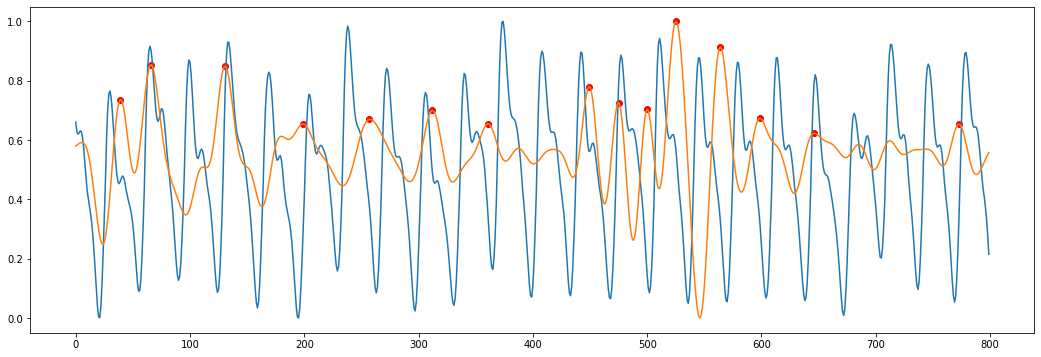

In [5]:
data = truths[test_subject - 1].prepare_data_for_ml()
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

beg = 1200
end = 2000

targ = y[beg: end]
targ = min_max_scale(targ)

# pred1 = rf.predict(x)[beg: end]
# pred1 = rf._process(pred1)
# pred1 = apply_wavelet(pred1, 'db2', 2)
# pred1 = min_max_scale(pred1)

pred2 = rf.predict2(x)[beg: end]
pred2 = rf._process(pred2)
pred2 = apply_wavelet(pred2, 'db2', 2)
pred2 = bandpass(pred2, 64, [0.67, 3.0], 4)
pred2 = min_max_scale(pred2)

pred_peaks, _ = get_peaks_v2(pred2, 64, 3.0, -1, prominence = 0.1, with_min_dist = True, with_valleys = False)
true_peaks, _ = get_peaks_v2(targ, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

plt.plot(targ)
plt.plot(pred2)
plt.scatter(pred_peaks, pred2[pred_peaks], c='r')

pred_ibis = get_ibis(pred_peaks, 64)
true_ibis = get_ibis(true_peaks, 64)
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')
